<a href="https://colab.research.google.com/github/yuvipaloozie/Data-Driven-Swing-Trading/blob/main/SwingTradingAlgoModel1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
!pip install yfinance ta xgboost plotly
!pip install --upgrade pandas

import yfinance as yf
import pandas as pd
import numpy as np
import ta
import xgboost as xgb
import matplotlib.pyplot as plt
import plotly.graph_objects as go # <-- ADD THIS
from plotly.subplots import make_subplots # <-- ADD THIS
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Suppress pandas warnings
pd.options.mode.chained_assignment = None  # default='warn'

In [49]:
# --- Cell 2: Configuration ---

# Asset Parameters
VOLATILE_TICKER = 'TSLA'
MARKET_TICKER = 'SPY'
START_DATE = '2015-01-01'
END_DATE = '2024-12-31'

# Triple Barrier Parameter
PROFIT_TAKE_PERC = 0.20
STOP_LOSS_PERC = 0.10
TIME_BARRIER_DAYS = 30

# Model Parameters
N_SPLITS = 5
PROB_THRESHOLD = 0.60
FEATURE_SET = [
    # Original Trend Features
    'RSI',
    'MACD',
    'EMA_DIST',
    'EMA_CROSS_MED',
    'EMA_CROSS_LONG',
    'ATR_PERCENT',

    'Hist_Vol_30D',
    'VIX_Close',

    'SPY_Regime',

    'Stoch_K',
    'Z_Score_20'
]

# Monte Carlo Parameters
N_SIMULATIONS = 5000
SIMULATION_DAYS = 252

In [50]:
print("\n--- 2. FETCHING DATA ---")
# Get data for the volatile stock
data = yf.download(VOLATILE_TICKER, start=START_DATE, end=END_DATE)

# Flatten MultiIndex columns if they exist
if isinstance(data.columns, pd.MultiIndex):
    data.columns = ['_'.join(col).strip() for col in data.columns.values]
# Rename columns to generic names (Open, High, Low, Close, Volume)
data = data.rename(columns={col: col.replace(f'_{VOLATILE_TICKER}', '') for col in data.columns if f'_{VOLATILE_TICKER}' in col})

# Get data for the market benchmark
market_data = yf.download(MARKET_TICKER, start=START_DATE, end=END_DATE)

# --- NEW: Get VIX Data ---
vix_data = yf.download('^VIX', start=START_DATE, end=END_DATE)

# Flatten MultiIndex columns for market_data too
if isinstance(market_data.columns, pd.MultiIndex):
    market_data.columns = ['_'.join(col).strip() for col in market_data.columns.values]
# Rename columns to generic names (Open, High, Low, Close, Volume)
market_data = market_data.rename(columns={col: col.replace(f'_{MARKET_TICKER}', '') for col in market_data.columns if f'_{MARKET_TICKER}' in col})

data['Market_Returns'] = market_data['Close'].pct_change()

# Calculate the stock's own returns for B&H comparison
data['Stock_Returns'] = data['Close'].pct_change()

print(f"Data loaded for {VOLATILE_TICKER} and {MARKET_TICKER}.")
print(data.head())

/tmp/ipython-input-3438043500.py:3: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


--- 2. FETCHING DATA ---



/tmp/ipython-input-3438043500.py:12: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3438043500.py:15: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


Data loaded for TSLA and SPY.
                Close       High        Low       Open    Volume  \
Date                                                               
2015-01-02  14.620667  14.883333  14.217333  14.858000  71466000   
2015-01-05  14.006000  14.433333  13.810667  14.303333  80527500   
2015-01-06  14.085333  14.280000  13.614000  14.004000  93928500   
2015-01-07  14.063333  14.318667  13.985333  14.223333  44526000   
2015-01-08  14.041333  14.253333  14.000667  14.187333  51637500   

            Market_Returns  Stock_Returns  
Date                                       
2015-01-02             NaN            NaN  
2015-01-05       -0.018060      -0.042041  
2015-01-06       -0.009419       0.005664  
2015-01-07        0.012461      -0.001562  
2015-01-08        0.017745      -0.001564  


In [51]:
print("\n--- 2b. PLOTTING HISTORICAL PRICE (CANDLESTICK) ---")

# Calculate MAs for plotting
data['SMA_200'] = data['Close'].rolling(window=200).mean()
data['EMA_200'] = ta.trend.ema_indicator(data['Close'], window=200)
data['EMA_100'] = ta.trend.ema_indicator(data['Close'], window=100)
data['EMA_50'] = ta.trend.ema_indicator(data['Close'], window=50)
# Create the figure
fig = go.Figure()

# Add the Candlestick trace
fig.add_trace(go.Candlestick(
    x=data.index,
    open=data['Open'],
    high=data['High'],
    low=data['Low'],
    close=data['Close'],
    name=f'{VOLATILE_TICKER} Candlesticks'
))

# Add the EMA traces
fig.add_trace(go.Scatter(
    x=data.index,
    y=data['EMA_200'],
    mode='lines',
    line=dict(color='orange', width=2),
    name='200-Day EMA'
))
fig.add_trace(go.Scatter(
    x=data.index,
    y=data['EMA_100'],
    mode='lines',
    line=dict(color='blue', width=2, dash='dot'),
    name='100-Day EMA'
))
fig.add_trace(go.Scatter(
    x=data.index,
    y=data['EMA_50'],
    mode='lines',
    line=dict(color='pink', width=2, dash='dot'),
    name='50-Day EMA'
))

# Update layout
fig.update_layout(
    title=f'{VOLATILE_TICKER} Historical Price Action ({START_DATE} to {END_DATE})',
    yaxis_title='Price (USD)',
    xaxis_title='Date',
    height=600,
    legend_title='Legend',
    # This disables the "range slider" at the bottom, which can be noisy
    xaxis_rangeslider_visible=False
)

# Set the y-axis to log scale, as you had before
fig.update_yaxes(type="log")

fig.show()


--- 2b. PLOTTING HISTORICAL PRICE (CANDLESTICK) ---


In [52]:
print("\n--- 3. ENGINEERING FEATURES ---")
# Add All TA Features (using the 'ta' library)
# This will add RSI, MACD, ATR, etc.
data = ta.add_all_ta_features(
    data, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True
)

# Create our selected features
data['RSI'] = data['momentum_rsi']
data['MACD'] = data['trend_macd_diff']
data['ATR_PERCENT'] = (data['volatility_atr'] / data['Close']) * 100

# --- HERE IS THE CHANGE ---
# (We already calculated SMA_200 and EMA_200 in the cell above)
# data['SMA_DIST'] = (data['Close'] - data['SMA_200']) / data['Close'] * 100 # <-- OLD
data['EMA_DIST'] = (data['Close'] - data['EMA_200']) / data['Close'] * 100 # <-- NEW
# Create the binary signal: 1 if 50-day is above 100-day, else 0
data['EMA_CROSS_MED'] = np.where(data['EMA_50'] > data['EMA_100'], 1, 0)

# --- 2. Long-Term Crossover (50 vs 200) ---
# We already have EMA_200 from Cell 4, but let's grab EMA_50 if it's not there
if 'EMA_50' not in data.columns:
    data['EMA_50'] = ta.trend.ema_indicator(data['Close'], window=50)
if 'EMA_200' not in data.columns:
    data['EMA_200'] = ta.trend.ema_indicator(data['Close'], window=200)

# Create the binary signal: 1 if 50-day is above 200-day, else 0
data['EMA_CROSS_LONG'] = np.where(data['EMA_50'] > data['EMA_200'], 1, 0)

print(f"Features created. Using feature set: {FEATURE_SET}")

# --- 1. Volatility Regime Features ---
# 30-Day Historical Volatility
data['Hist_Vol_30D'] = data['Stock_Returns'].rolling(window=30).std() * np.sqrt(252)

# Add VIX close price
# This will align the VIX data to your stock's trading days
data['VIX_Close'] = vix_data['Close']
data['VIX_Close'] = data['VIX_Close'].ffill() # Fill any non-trading days (holidays)

# --- 2. Market Regime Feature ---
# Calculate SPY's trend
spy_ema_50 = ta.trend.ema_indicator(market_data['Close'], window=50)
spy_ema_200 = ta.trend.ema_indicator(market_data['Close'], window=200)

# 1 if SPY is in an uptrend, 0 if in downtrend
market_data['SPY_Regime'] = np.where(spy_ema_50 > spy_ema_200, 1, 0)

# Map the SPY regime to our main dataframe
data['SPY_Regime'] = market_data['SPY_Regime']
data['SPY_Regime'] = data['SPY_Regime'].ffill()

# --- 3. Mean-Reversion (Oscillator) Features ---
# Stochastic Oscillator (%K)
data['Stoch_K'] = ta.momentum.stoch(data['High'], data['Low'], data['Close'], window=14)

# Z-Score (how many std devs from 20-day mean)
sma_20 = data['Close'].rolling(window=20).mean()
std_20 = data['Close'].rolling(window=20).std()
data['Z_Score_20'] = (data['Close'] - sma_20) / std_20


# --- Final Check ---
print(f"Features created. Using feature set: {FEATURE_SET}")
# Display the new features to make sure they're not all NaN
print(data[FEATURE_SET].tail())


--- 3. ENGINEERING FEATURES ---


/usr/local/lib/python3.12/dist-packages/ta/trend.py:1030: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`



Features created. Using feature set: ['RSI', 'MACD', 'EMA_DIST', 'EMA_CROSS_MED', 'EMA_CROSS_LONG', 'ATR_PERCENT', 'Hist_Vol_30D', 'VIX_Close', 'SPY_Regime', 'Stoch_K', 'Z_Score_20']
Features created. Using feature set: ['RSI', 'MACD', 'EMA_DIST', 'EMA_CROSS_MED', 'EMA_CROSS_LONG', 'ATR_PERCENT', 'Hist_Vol_30D', 'VIX_Close', 'SPY_Regime', 'Stoch_K', 'Z_Score_20']
                  RSI      MACD   EMA_DIST  EMA_CROSS_MED  EMA_CROSS_LONG  \
Date                                                                        
2024-12-23  62.731818 -0.807371  39.205807              1               1   
2024-12-24  68.422829 -0.059537  42.940463              1               1   
2024-12-26  65.645587 -0.422695  41.499372              1               1   
2024-12-27  58.585163 -2.376070  38.071501              1               1   
2024-12-30  54.576261 -4.693767  35.599534              1               1   

            ATR_PERCENT  Hist_Vol_30D  VIX_Close  SPY_Regime    Stoch_K  \
Date               

/tmp/ipython-input-3492184419.py:34: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipython-input-3492184419.py:38: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipython-input-3492184419.py:50: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipython-input-3492184419.py:55: PerformanceWarn

In [53]:
# --- Cell 6: Plotting Features (Quant Dashboard) ---

print("\n--- 3b. PLOTTING NEW QUANT DASHBOARD ---")
# We'll plot the last 3 years of data to make it readable
plot_data = data.loc['2022-01-01':]

# Create a 4-row dashboard
fig = make_subplots(
    rows=4,
    cols=1,
    shared_xaxes=True,
    vertical_spacing=0.03,
    subplot_titles=(
        '1. Price Action',
        '2. Mean-Reversion Oscillators',
        '3. Volatility Regime',
        '4. Trend & Market Regime'
    ),
    specs=[[{"secondary_y": False}],  # Row 1 (Price)
           [{"secondary_y": True}],   # Row 2 (Mean Reversion)
           [{"secondary_y": True}],   # Row 3 (Volatility)
           [{"secondary_y": False}]]  # Row 4 (Trend)
)

# --- 1. Price ---
fig.add_trace(go.Candlestick(
    x=plot_data.index,
    open=plot_data['Open'], high=plot_data['High'],
    low=plot_data['Low'], close=plot_data['Close'],
    name='Price'
), row=1, col=1)
fig.update_yaxes(title_text="Price", row=1, col=1)

# --- 2. Mean Reversion ---
# Stochastic
fig.add_trace(go.Scatter(
    x=plot_data.index, y=plot_data['Stoch_K'],
    mode='lines', line=dict(color='purple'), name='Stoch %K'
), row=2, col=1)
fig.add_hline(y=80, line=dict(color='red', dash='dot'), row=2, col=1)
fig.add_hline(y=20, line=dict(color='green', dash='dot'), row=2, col=1)
# Z-Score
# We need a secondary y-axis for Z-Score
fig.add_trace(go.Scatter(
    x=plot_data.index, y=plot_data['Z_Score_20'],
    mode='lines', line=dict(color='orange'), name='Z-Score (20d)'
), row=2, col=1, secondary_y=True)
fig.update_yaxes(title_text="Stochastic", row=2, col=1, secondary_y=False)
fig.update_yaxes(title_text="Z-Score", row=2, col=1, secondary_y=True)


# --- 3. Volatility Regime ---
fig.add_trace(go.Scatter(
    x=plot_data.index, y=plot_data['Hist_Vol_30D'],
    mode='lines', line=dict(color='blue'), name='Hist. Vol (30d)'
), row=3, col=1)
# VIX on secondary axis
fig.add_trace(go.Scatter(
    x=plot_data.index, y=plot_data['VIX_Close'],
    mode='lines', line=dict(color='gray'), name='VIX'
), row=3, col=1, secondary_y=True)
fig.update_yaxes(title_text="Stock Vol", row=3, col=1, secondary_y=False)
fig.update_yaxes(title_text="VIX", row=3, col=1, secondary_y=True)

# --- 4. Trend & Market Regime ---
# These are binary (0 or 1), so they plot as "steps"
fig.add_trace(go.Scatter(
    x=plot_data.index, y=plot_data['EMA_CROSS_LONG'],
    mode='lines', line=dict(color='green', width=2), name='Stock Trend (50>200)'
), row=4, col=1)
fig.add_trace(go.Scatter(
    x=plot_data.index, y=plot_data['SPY_Regime'],
    mode='lines', line=dict(color='red', dash='dot', width=2), name='Market Trend (SPY)'
), row=4, col=1)
fig.update_yaxes(title_text="Regime (1=On)", row=4, col=1)


# --- Update Layout ---
fig.update_layout(
    height=1200, # This is a tall chart
    title_text=f'{VOLATILE_TICKER} Quant Dashboard (2022-Present)',
    xaxis_rangeslider_visible=False,
    legend_title='Legend'
)
fig.show()


--- 3b. PLOTTING NEW QUANT DASHBOARD ---


In [54]:
print("\n--- 4. CREATING TRIPLE BARRIER LABELS ---")

def get_triple_barrier_labels(prices, profit_take_perc, stop_loss_perc, time_barrier_days):
    labels = pd.Series(np.nan, index=prices.index)

    for i in range(len(prices)):
        entry_price = prices.iloc[i]
        profit_target = entry_price * (1 + profit_take_perc)
        stop_loss_target = entry_price * (1 - stop_loss_perc)
        window = prices.iloc[i+1 : i+1+TIME_BARRIER_DAYS]

        if window.empty:
            break

        profit_hit = window[window >= profit_target].first_valid_index()
        stop_loss_hit = window[window <= stop_loss_target].first_valid_index()

        if profit_hit is None and stop_loss_hit is None:
            labels.iloc[i] = 0
        elif profit_hit is not None and stop_loss_hit is None:
            labels.iloc[i] = 1
        elif profit_hit is None and stop_loss_hit is not None:
            labels.iloc[i] = 0
        else:
            if profit_hit < stop_loss_hit:
                labels.iloc[i] = 1
            else:
                labels.iloc[i] = 0

    return labels

# Create the labels
data['label'] = get_triple_barrier_labels(
    data['Close'],
    profit_take_perc=PROFIT_TAKE_PERC,
    stop_loss_perc=STOP_LOSS_PERC,
    time_barrier_days=TIME_BARRIER_DAYS
)
print("Labels created.")


--- 4. CREATING TRIPLE BARRIER LABELS ---
Labels created.


/tmp/ipython-input-2604723296.py:33: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning:

[18:31:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.





--- 5. PREPARING DATA & TRAINING MODEL (WALK-FORWARD) ---
Total samples for training: 2315
Class distribution (1=Win, 0=Loss/Timeout):
label
0.0    0.713607
1.0    0.286393
Name: proportion, dtype: float64

Starting walk-forward training...
  Split 1/5 complete. Test F1-Score: 0.1944 (Accuracy: 0.5481)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning:

[18:31:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.




  Split 2/5 complete. Test F1-Score: 0.1705 (Accuracy: 0.4442)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning:

[18:31:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.




  Split 3/5 complete. Test F1-Score: 0.4143 (Accuracy: 0.6182)
  Split 4/5 complete. Test F1-Score: 0.3514 (Accuracy: 0.6260)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning:

[18:31:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning:

[18:31:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.




  Split 5/5 complete. Test F1-Score: 0.2420 (Accuracy: 0.6909)
Model training complete.

Plotting feature importance from last-trained model...


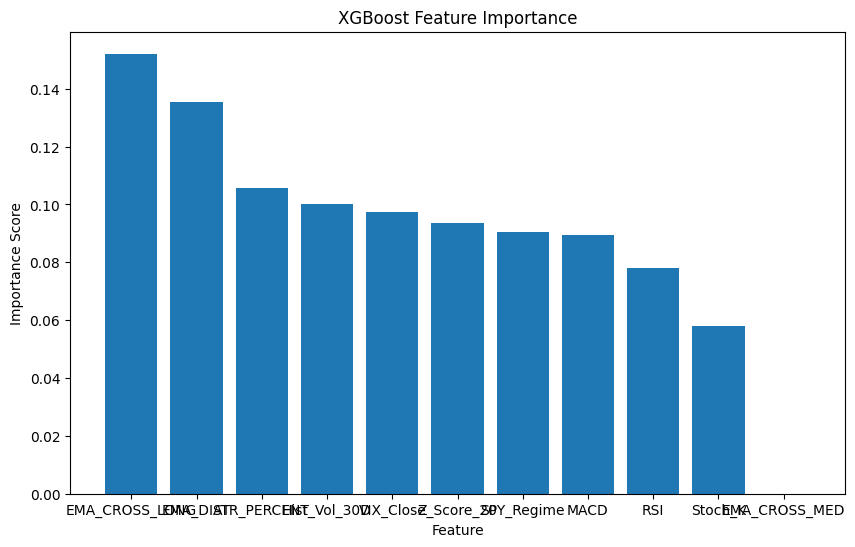

           Feature  Importance
4   EMA_CROSS_LONG    0.152146
2         EMA_DIST    0.135312
5      ATR_PERCENT    0.105756
6     Hist_Vol_30D    0.100044
7        VIX_Close    0.097539
10      Z_Score_20    0.093451
8       SPY_Regime    0.090325
1             MACD    0.089420
0              RSI    0.077904
9          Stoch_K    0.058102
3    EMA_CROSS_MED    0.000000


In [55]:
from sklearn.metrics import f1_score # <-- ADD THIS
print("\n--- 5. PREPARING DATA & TRAINING MODEL (WALK-FORWARD) ---")
# Create final X and y
X = data[FEATURE_SET]
y = data['label']

# --- Clean data ---
combined = pd.concat([X, y], axis=1).dropna()
X = combined[FEATURE_SET]
y = combined['label']

print(f"Total samples for training: {len(y)}")
print(f"Class distribution (1=Win, 0=Loss/Timeout):\n{y.value_counts(normalize=True)}")

# --- Walk-Forward Training with TimeSeriesSplit ---
tscv = TimeSeriesSplit(n_splits=N_SPLITS)
all_predictions = pd.Series(np.nan, index=y.index)
all_probs = pd.Series(np.nan, index=y.index)

print("\nStarting walk-forward training...")
split_num = 1
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    weight_ratio = y_train.value_counts()[0.0] / y_train.value_counts()[1.0]

    model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        n_estimators=100,
        random_state=42,
        scale_pos_weight=weight_ratio,

        max_depth=3,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8
    )

    model.fit(X_train_scaled, y_train)

    test_probs = model.predict_proba(X_test_scaled)[:, 1]
    test_preds = (test_probs > PROB_THRESHOLD).astype(int)

    all_predictions.iloc[test_index] = test_preds
    all_probs.iloc[test_index] = test_probs

    f1 = f1_score(y_test, test_preds)
    print(f"  Split {split_num}/{N_SPLITS} complete. Test F1-Score: {f1:.4f} (Accuracy: {accuracy_score(y_test, test_preds):.4f})")
    split_num += 1

print("Model training complete.")
# --- PLOT FEATURE IMPORTANCE ---
# This plots the features from the FINAL trained model in our loop
print("\nPlotting feature importance from last-trained model...")
try:
    # Get importance
    importance = model.feature_importances_

    # Create a DataFrame for easy plotting
    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importance
    }).sort_values(by='Importance', ascending=False)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'])
    plt.title('XGBoost Feature Importance')
    plt.xlabel('Feature')
    plt.ylabel('Importance Score')
    plt.show()

    print(feature_importance_df)

except Exception as e:
    print(f"Could not plot feature importance: {e}")

In [56]:
print("\n--- 6. RUNNING HISTORICAL BACKTEST ---")
# Create a new DataFrame for our backtest results
backtest_df = data.loc[all_predictions.index].copy()
backtest_df['Signal_Prob'] = all_probs
backtest_df['Signal'] = all_predictions

# IMPORTANT: We shift the signal by 1.
backtest_df['Signal'] = backtest_df['Signal'].shift(1)

# Calculate strategy returns
backtest_df['Strategy_Returns'] = backtest_df['Stock_Returns'] * backtest_df['Signal']

# --- Calculate Cumulative Returns ---
backtest_df['Cumulative_Strategy_Returns'] = (1 + backtest_df['Strategy_Returns']).cumprod()
backtest_df['Cumulative_Stock_BH_Returns'] = (1 + backtest_df['Stock_Returns']).cumprod()
backtest_df['Cumulative_Market_BH_Returns'] = (1 + backtest_df['Market_Returns']).cumprod()

print("Backtest calculations complete.")


--- 6. RUNNING HISTORICAL BACKTEST ---
Backtest calculations complete.


In [57]:
print("\n--- 6b. PLOTTING TRADE SIGNALS ON PRICE ACTION (CANDLESTICK) ---")

# Get the times our model was "IN" the market
buy_signals = backtest_df[backtest_df['Signal'] == 1]

# We'll plot just the last ~2 years of signals to see them clearly
plot_df = backtest_df.loc['2022-01-01':]
plot_signals = buy_signals.loc['2022-01-01':]

# Create the figure
fig = go.Figure()

# --- 1. Add Candlestick Trace ---
fig.add_trace(go.Candlestick(
    x=plot_df.index,
    open=plot_df['Open'],
    high=plot_df['High'],
    low=plot_df['Low'],
    close=plot_df['Close'],
    name=f'{VOLATILE_TICKER} Price'
))

# --- 2. Add "IN" Signal Markers ---
fig.add_trace(go.Scatter(
    x=plot_signals.index,
    # Place the marker just below the low of that day for visibility
    y=plot_signals['Low'] * 0.98,
    mode='markers',
    marker=dict(
        color='green',
        symbol='triangle-up',
        size=10
    ),
    name=f'Model "IN" (Prob > {PROB_THRESHOLD})'
))

# --- Update Layout ---
fig.update_layout(
    title=f'Model Signals on {VOLATILE_TICKER} Price (2022-Present)',
    xaxis_title='Date',
    yaxis_title='Price (USD)',
    height=600,
    xaxis_rangeslider_visible=False,
    legend_title='Legend'
)

fig.show()


--- 6b. PLOTTING TRADE SIGNALS ON PRICE ACTION (CANDLESTICK) ---



--- 7. PLOTTING CUMULATIVE RETURNS (EQUITY CURVE) ---
Plot saved as 'strategy_comparison.png'


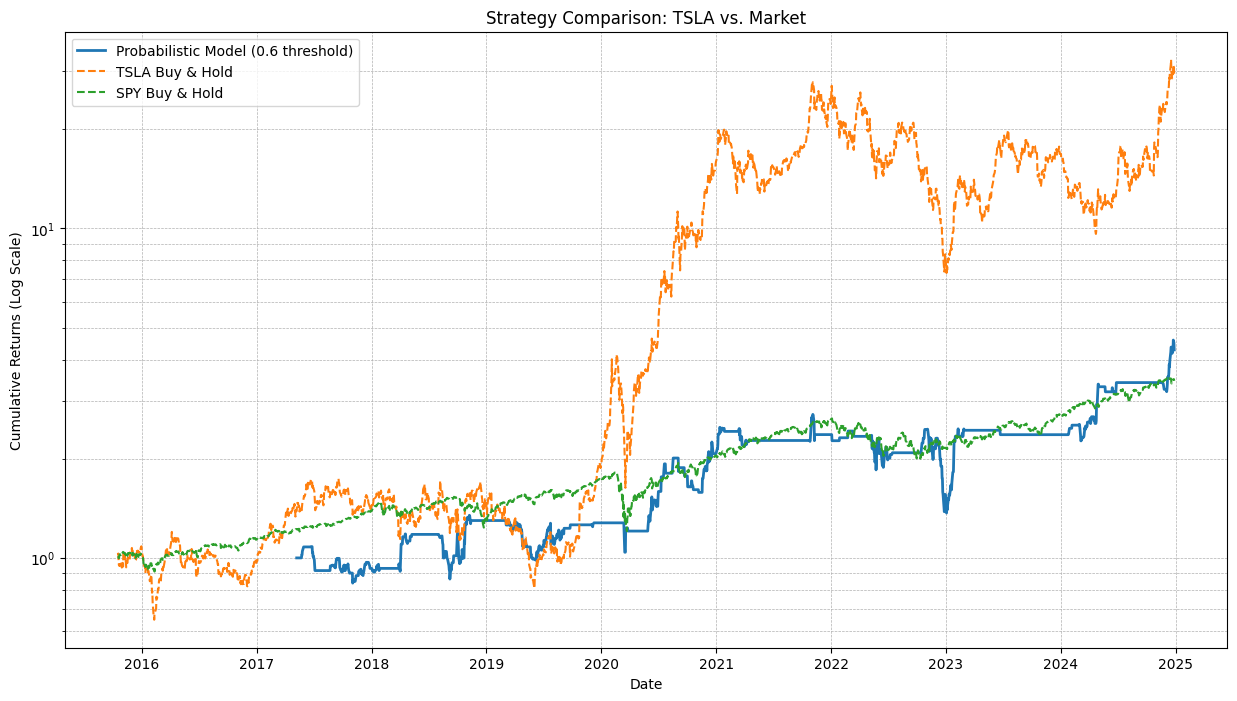


Historical Performance Metrics
Strategy Returns: 4.28x
TSLA B&H Returns: 29.26x
SPY B&H Returns: 3.45x


In [58]:
print("\n--- 7. PLOTTING CUMULATIVE RETURNS (EQUITY CURVE) ---")
plt.figure(figsize=(15, 8))
plt.plot(
    backtest_df['Cumulative_Strategy_Returns'],
    label=f"Probabilistic Model ({PROB_THRESHOLD} threshold)",
    linewidth=2
)
plt.plot(
    backtest_df['Cumulative_Stock_BH_Returns'],
    label=f"{VOLATILE_TICKER} Buy & Hold",
    linestyle='--',
    linewidth=1.5
)
plt.plot(
    backtest_df['Cumulative_Market_BH_Returns'],
    label=f"{MARKET_TICKER} Buy & Hold",
    linestyle='--',
    linewidth=1.5
)

plt.title(f'Strategy Comparison: {VOLATILE_TICKER} vs. Market')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns (Log Scale)')
plt.yscale('log')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.savefig('strategy_comparison.png')
print("Plot saved as 'strategy_comparison.png'")
plt.show()

# Print final performance
try:
    print("\nHistorical Performance Metrics")
    print(f"Strategy Returns: {backtest_df['Cumulative_Strategy_Returns'].iloc[-1]:.2f}x")
    print(f"{VOLATILE_TICKER} B&H Returns: {backtest_df['Cumulative_Stock_BH_Returns'].iloc[-1]:.2f}x")
    print(f"{MARKET_TICKER} B&H Returns: {backtest_df['Cumulative_Market_BH_Returns'].iloc[-1]:.2f}x")
except Exception as e:
    print(f"Could not print final performance: {e}")

In [59]:
print("Running Stress Test")

strategy_daily_returns = backtest_df['Strategy_Returns'].dropna()

sim_results = np.zeros((SIMULATION_DAYS + 1, N_SIMULATIONS))
sim_results[0, :] = 1.0

for i in range(N_SIMULATIONS):
    sim_returns = np.random.choice(
        strategy_daily_returns,
        SIMULATION_DAYS,
        replace=True
    )
    sim_results[1:, i] = (1 + sim_returns).cumprod()

print(f"Ran {N_SIMULATIONS} simulations of {SIMULATION_DAYS} days each.")

Running Stress Test
Ran 5000 simulations of 252 days each.


Monte Carlo Plot
Plot saved as 'monte_carlo_spaghetti.png'


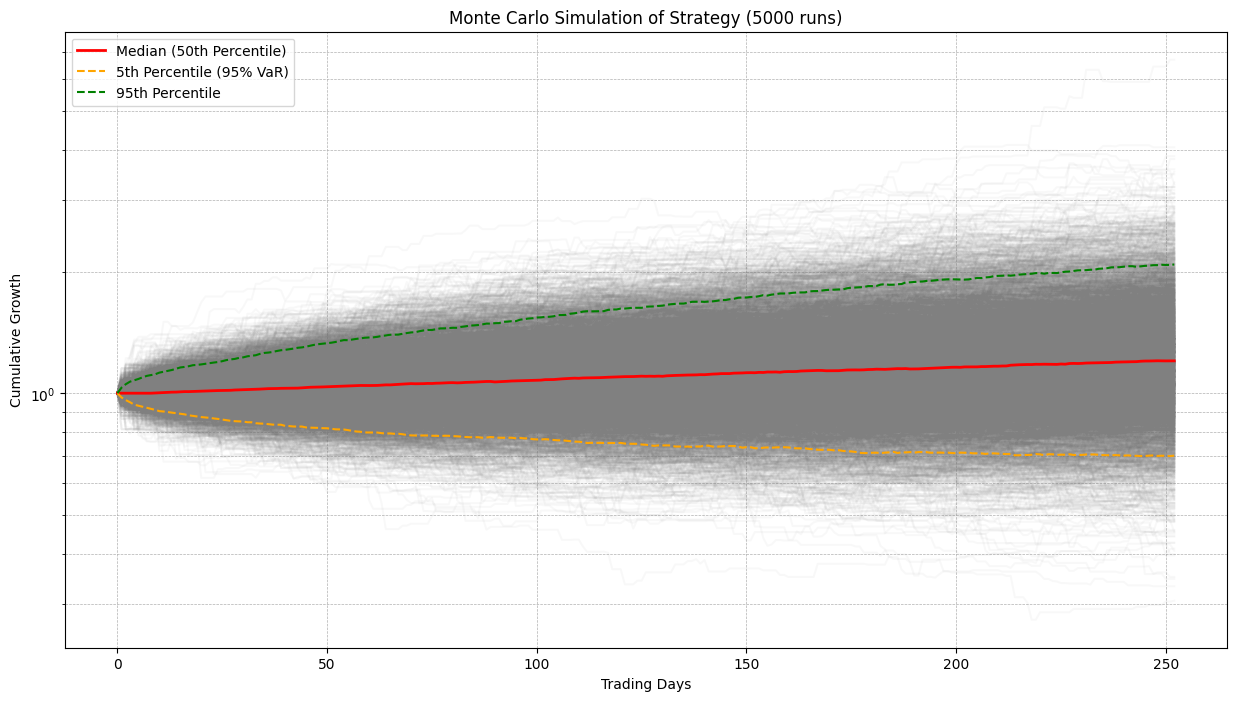

In [60]:
print("Monte Carlo Plot")

plt.figure(figsize=(15, 8))
plt.plot(sim_results, color='gray', alpha=0.05)
plt.plot(
    np.median(sim_results, axis=1),
    color='red',
    linewidth=2,
    label='Median (50th Percentile)'
)
plt.plot(
    np.percentile(sim_results, 5, axis=1),
    color='orange',
    linestyle='--',
    label='5th Percentile (95% VaR)'
)
plt.plot(
    np.percentile(sim_results, 95, axis=1),
    color='green',
    linestyle='--',
    label='95th Percentile'
)
plt.title(f'Monte Carlo Simulation of Strategy ({N_SIMULATIONS} runs)')
plt.xlabel('Trading Days')
plt.ylabel('Cumulative Growth')
plt.yscale('log')
plt.legend(loc='upper left')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.savefig('monte_carlo_spaghetti.png')
print("Plot saved as 'monte_carlo_spaghetti.png'")
plt.show()

In [62]:
print("Monte Carlo 1-Year (252-day) Risk Metrics")
final_outcomes = sim_results[-1, :]
median_return = np.median(final_outcomes)
var_5_percent = np.percentile(final_outcomes, 5)
var_1_percent = np.percentile(final_outcomes, 1)

print(f"Median 1-Year Growth: {median_return:.2f}x")
print(f"95th Percentile Growth: {np.percentile(final_outcomes, 95):.2f}x")
print(f"Worst 5% of outcomes (95% VaR): {var_5_percent:.2f}x (a loss of {(1-var_5_percent)*100:.2f}% or more)")
print(f"Worst 1% of outcomes (99% VaR): {var_1_percent:.2f}x (a loss of {(1-var_1_percent)*100:.2f}% or more)")

Monte Carlo 1-Year (252-day) Risk Metrics
Median 1-Year Growth: 1.20x
95th Percentile Growth: 2.08x
Worst 5% of outcomes (95% VaR): 0.70x (a loss of 29.94% or more)
Worst 1% of outcomes (99% VaR): 0.55x (a loss of 45.27% or more)
